# **Financial Applicactions with ML & AI**

<img style="float: right;" src="https://github.com/torreblanca99/course_financial_applications/blob/develop/docs/img/logo_bourbaki.png?raw=1" width="100"/>

## **Module II:** Value Risk
#### Topic: Hierarchical Risk Parity (HRP)for Portfolio Management

##### Name: Julio César Avila Torreblanca

- **Objective**: apply HRP for creating a portfolio
- **Contents**:
    - Notes:
        - Hierarchical Risk Parity
    - Code:
        1. Libraries and parameters
        2. Read Data (Asset example)
        3. EDA
        4. Preparing Data
        5. Modeling
        6. Evaluation
----

# Hierarchical Risk Parity (HRP)

## Introduction

Hierarchical Risk Parity (HRP) is an advanced portfolio management algorithm that utilizes hierarchical clustering techniques to allocate weights in a portfolio. It is particularly useful in scenarios where we want to diversify the risk by clustering the assets based on their covariance structure.

## Purpose

The main purpose of HRP is to construct a portfolio that minimizes risk through effective diversification. Unlike traditional methods that may assume equal correlation or linear dependence, HRP takes into account the hierarchical structure and relationships amongst the assets, offering a more robust allocation strategy, especially in volatile markets.

## Algorithm Explanation

The HRP algorithm involves several key steps:

1. **Tree Clustering of Assets:**
   HRP begins by performing hierarchical clustering on assets using the covariance matrix. Two paradigms in clustering include:
   - If two elements are close, they should belong to the same cluster.
   - If two elements are in the same cluster, they are close.

2. **Recursive Bisection:**
   The assets are divided into clusters recursively, assigning weights with the goal of balancing the risk contribution at each level of the hierarchy.

3. **Inverse-Variance Allocation within Clusters:**
   Within each identified cluster, weights are allocated based on the inverse variance of each asset to ensure that less volatile assets are given more weight.

## Mathematical Formulation

While the core idea revolves around clustering and risk balancing, the precise mathematical nature of HRP includes:

- **Distance Measures:** Two types of distances between potential clusters $ A $ and $ B $.
  - $ D_1(A, B) = \min_{a \in A, b \in B} d(a, b) $
  - $ D_2(A, B) = \max_{a \in A, b \in B} d(a, b) $

## Advantages

- **Non-Parametric:** Does not rely on assumptions about the distribution of returns.
- **Robust to Nonlinear Dependencies:** Accounts for hierarchical and nonlinear relationships among assets.
- **Effective in Diverse Market Conditions:** Provides reliable weight allocation in both stable and volatile markets.

## Disadvantages

- **Complexity:** More computationally intensive than traditional mean-variance optimization.
- **Interpretability:** The hierarchical structure can be less intuitive to interpret for some practitioners.

By leveraging the natural groupings in asset returns, Hierarchical Risk Parity aims to construct portfolios that are better risk-balanced than those constructed by traditional mean-variance optimization.

---

## Critical Line Algorithm (CLA)

Critical Line Algorithm (CLA) is an algorithm for obtaining minimum variance portfolios without the need for quadratic programming.

Obtained from:

> David H. Bailey and Marcos Lopez de Prado, "An open-source implementation of the critical line algorithm for portfolio optimization," Algorithms, vol. 6 (2013), pg. 169-196, DOI: 10.3390/a6010169

The [publication](https://ssrn.com/abstract=2197616) and [code](https://www.davidhbailey.com/dhbpapers/CLA-files.zip) can be found at https://www.davidhbailey.com/dhbpapers/.
Let me know if there's anything else you need!

In [4]:
%%writefile CLA.py
# !/usr/bin/env python
# On 20121129
# Critical Line Algorithm
# by MLdP <lopezdeprado@lbl.gov>

import numpy as np
#---------------------------------------------------------------
#---------------------------------------------------------------
class CLA:
    def __init__(self,mean,covar,lB,uB):
        # Initialize the class
        self.mean=mean
        self.covar=covar
        self.lB=lB
        self.uB=uB
        self.w=[] # solution
        self.l=[] # lambdas
        self.g=[] # gammas
        self.f=[] # free weights
#---------------------------------------------------------------
    def solve(self):
        # Compute the turning points,free sets and weights
        f,w=self.initAlgo()
        self.w.append(np.copy(w)) # store solution
        self.l.append(None)
        self.g.append(None)
        self.f.append(f[:])
        while True:
            #1) case a): Bound one free weight
            l_in=None
            if len(f)>1:
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                j=0
                for i in f:
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,j,[self.lB[i],self.uB[i]])
                    if l_in is None or l>l_in:l_in,i_in,bi_in=l,i,bi
                    j+=1
            #2) case b): Free one bounded weight
            l_out=None
            if len(f)<self.mean.shape[0]:
                b=self.getB(f)
                for i in b:
                    covarF,covarFB,meanF,wB=self.getMatrices(f+[i])
                    covarF_inv=np.linalg.inv(covarF)
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,meanF.shape[0]-1, \
                        self.w[-1][i])
                    if (self.l[-1]==None or l<self.l[-1]) and (l_out is None or l>l_out):
                        l_out,i_out=l,i
            #3) decide lambda
            if (l_in==None or l_in<0) and (l_out==None or l_out<0):break
            if l_in is not None and (l_out is None or l_in > l_out):
                self.l.append(l_in)
                f.remove(i_in)
                w[i_in]=bi_in # set value at the correct boundary
            else:
                self.l.append(l_out)
                f.append(i_out)
            #4) compute solution vector
            covarF,covarFB,meanF,wB=self.getMatrices(f)
            covarF_inv=np.linalg.inv(covarF)
            wF,g=self.computeW(covarF_inv,covarFB,meanF,wB)
            for i in range(len(f)):w[f[i]]=wF[i]
            self.w.append(np.copy(w)) # store solution
            self.g.append(g)
            self.f.append(f[:])
            if len(f)==self.mean.shape[0]:
                #5) minimum variance solution
                wF,g=self.computeW(covarF_inv,covarFB,np.zeros(meanF.shape),wB)
                for i in range(len(f)):w[f[i]]=wF[i]
                self.w.append(np.copy(w)) # store solution
                self.g.append(g)
                self.f.append(f[:])
#---------------------------------------------------------------
    def initAlgo(self):
        # Initialize the algo
        #1) Form structured array
        a=np.zeros((self.mean.shape[0]),dtype=[('id',int),('mu',float)])
        b=[self.mean[i][0] for i in range(self.mean.shape[0])] # dump array into list
        a[:]=list(zip(range(self.mean.shape[0]),b)) # fill structured array
        #2) Sort structured array
        b=np.sort(a,order='mu')
        #3) First free weight
        i,w=b.shape[0],np.copy(self.lB)
        while sum(w)<1:
            i-=1
            w[b[i][0]]=self.uB[b[i][0]]
        w[b[i][0]]+=1-sum(w)
        return [b[i][0]],w
#---------------------------------------------------------------
    def computeBi(self,c,bi):
        if c>0:
            bi=bi[1]
        if c<0:
            bi=bi[0]
        return bi
#---------------------------------------------------------------
    def computeW(self,covarF_inv,covarFB,meanF,wB):
        #1) compute gamma
        onesF=np.ones(meanF.shape)
        g1=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        g2=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        if np.all(wB)==None:
            g,w1=float(-self.l[-1]*g1/g2+1/g2),0
        else:
            onesB=np.ones(wB.shape)
            g3=np.dot(onesB.T,wB)
            g4=np.dot(covarF_inv,covarFB)
            w1=np.dot(g4,wB)
            g4=np.dot(onesF.T,w1)
            g=float(-self.l[-1]*g1/g2+(1-g3+g4)/g2)
        #2) compute weights
        w2=np.dot(covarF_inv,onesF)
        w3=np.dot(covarF_inv,meanF)
        return -w1+g*w2+self.l[-1]*w3,g
#---------------------------------------------------------------
    def computeLambda(self,covarF_inv,covarFB,meanF,wB,i,bi):
        #1) C
        onesF=np.ones(meanF.shape)
        c1=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        c2=np.dot(covarF_inv,meanF)
        c3=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        c4=np.dot(covarF_inv,onesF)
        c=-c1*c2[i]+c3*c4[i]
        if c==0:return
        #2) bi
        if type(bi)==list:bi=self.computeBi(c,bi)
        #3) Lambda
        if np.all(wB==None):
            # All free assets
            return float((c4[i]-c1*bi)/c),bi
        else:
            onesB=np.ones(wB.shape)
            l1=np.dot(onesB.T,wB)
            l2=np.dot(covarF_inv,covarFB)
            l3=np.dot(l2,wB)
            l2=np.dot(onesF.T,l3)
            return float(((1-l1+l2)*c4[i]-c1*(bi+l3[i]))/c),bi
#---------------------------------------------------------------
    def getMatrices(self,f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF=self.reduceMatrix(self.covar,f,f)
        meanF=self.reduceMatrix(self.mean,f,[0])
        b=self.getB(f)
        covarFB=self.reduceMatrix(self.covar,f,b)
        wB=self.reduceMatrix(self.w[-1],b,[0])
        return covarF,covarFB,meanF,wB
#---------------------------------------------------------------
    def getB(self,f):
        return self.diffLists(range(self.mean.shape[0]),f)
#---------------------------------------------------------------
    def diffLists(self,list1,list2):
        return list(set(list1)-set(list2))
#---------------------------------------------------------------
    def reduceMatrix(self,matrix,listX,listY):
        matrix = np.array(matrix)
        # Reduce a matrix to the provided list of rows and columns
        if len(listX)==0 or len(listY)==0:return
        matrix_=matrix[:,listY[0]:listY[0]+1]
        for i in listY[1:]:
            a=matrix[:,i:i+1]
            matrix_=np.append(matrix_,a,1)
        matrix__=matrix_[listX[0]:listX[0]+1,:]
        for i in listX[1:]:
            a=matrix_[i:i+1,:]
            matrix__=np.append(matrix__,a,0)
        return matrix__
#---------------------------------------------------------------
    def getMinVar(self):
        # Get the minimum variance solution
        var=[]
        for w in self.w:
            a=np.dot(np.dot(w.T,self.covar),w)
            var.append(a)
        return min(var)**.5,self.w[var.index(min(var))]
#---------------------------------------------------------------
    def getMaxSR(self):
        # Get the max Sharpe ratio portfolio
        #1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr,sr=[],[]
        for i in range(len(self.w)-1):
            w0=np.copy(self.w[i])
            w1=np.copy(self.w[i+1])
            kargs={'minimum':False,'args':(w0,w1)}
            a,b=self.goldenSection(self.evalSR,0,1,**kargs)
            w_sr.append(a*w0+(1-a)*w1)
            sr.append(b)
        return max(sr),w_sr[sr.index(max(sr))]
#---------------------------------------------------------------
    def evalSR(self,a,w0,w1):
        # Evaluate SR of the portfolio within the convex combination
        w=a*w0+(1-a)*w1
        b=np.dot(w.T,self.mean)[0,0]
        c=np.dot(np.dot(w.T,self.covar),w)[0,0]**.5
        return b/c
#---------------------------------------------------------------
    def goldenSection(self,obj,a,b,**kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed
        from math import log,ceil
        tol,sign,args=1.0e-9,1,None
        if 'minimum' in kargs and kargs['minimum']==False:sign=-1
        if 'args' in kargs:args=kargs['args']
        numIter=int(ceil(-2.078087*log(tol/abs(b-a))))
        r=0.618033989
        c=1.0-r
        # Initialize
        x1=r*a+c*b;x2=c*a+r*b
        f1=sign*obj(x1,*args);f2=sign*obj(x2,*args)
        # Loop
        for i in range(numIter):
            if f1>f2:
                a=x1
                x1=x2;f1=f2
                x2=c*a+r*b;f2=sign*obj(x2,*args)
            else:
                b=x2
                x2=x1;f2=f1
                x1=r*a+c*b;f1=sign*obj(x1,*args)
        if f1<f2:return x1,sign*f1
        else:return x2,sign*f2
#---------------------------------------------------------------
    def efFrontier(self,points):
        # Get the efficient frontier
        mu,sigma,weights=[],[],[]
        a=np.linspace(0,1,points/len(self.w))[:-1] # remove the 1, to avoid duplications
        b=range(len(self.w)-1)
        for i in b:
            w0,w1=self.w[i],self.w[i+1]
            if i==b[-1]:a=np.linspace(0,1,points/len(self.w)) # include the 1 in the last iteration
            for j in a:
                w=w1*j+(1-j)*w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T,self.mean)[0,0])
                sigma.append(np.dot(np.dot(w.T,self.covar),w)[0,0]**.5)
        return mu,sigma,weights
#---------------------------------------------------------------
#---------------------------------------------------------------

Writing CLA.py


# 1. Libraries & parameters

In [1]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

import random
import numpy as np
import pandas as pd

import yfinance as yf

from scipy.spatial.distance import squareform

from CLA import CLA

## 1.1 Functions

Next functions creates a portfolio in which the weights assigned to each asset will be taken as the inverse-variances (more secure inversions).

In [2]:
def getIVP(cov,**kwargs):
    # Compute the inverse-variance portfolio
    ivp = 1./np.diag(cov)
    ivp /= ivp.sum()
    
    return ivp

This is the portfolio varianze $\omega^{T} \sum \omega$.

In [3]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems,cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
    
    return cVar

Next function works to reorganize rows and columns of the covariance matriz in order that the higher values are moved near the diagonal.

In [19]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1,0],link[-1,1]])
    numItems = link[-1,3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0,sortIx.shape[0]*2,2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index;j = df0.values-numItems
        sortIx[i] = link[j,0] # item 1
        df0 = pd.Series(link[j,1],index = i+1)
        sortIx = sortIx._append(df0) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

# Hierarchical Risk Parity (HRP) Weight Calculation

Hierarchical Risk Parity (HRP) is a portfolio allocation algorithm that clusters assets into groups and then assigns weights based on inverse-variance. The following steps detail the process:

## Algorithm Steps

1. **Initialization:**

   - Create a list of objects: $ L = \{ L_0 \} $ with $ L_0 = \{ n \}_{n=1, \dots, N} $
   
   - Assign a unit weight to all objects: $ w_n = 1 $, $ \forall n = 1, \dots, N $

2. **Stopping Criterion:**

   - If $ \|L_i\| = 1 $, $ \forall L_i \in L $, then stop the algorithm.

3. **Bisection:**

   - For each $ L_i \in L $ such that $ \|L_i\| > 1 $:

     a. Bisect $ L_i $ into two subsets, $ L_i^{(1)} \cup L_i^{(2)} = L_i $, where $ \|L_i^{(1)}\| = \text{int}\left( \frac{1}{2}\|L_i\| \right) $, preserving the order.

     b. Define the variance of $ L_i^{(j)} $, $ j = 1, 2 $ as the quadratic form:
        $$
        \tilde{V}_i^{(j)} \equiv \tilde{w}_i^{(j)^{T}} V_i^{(j)} \tilde{w}_i^{(j)}
        $$
        where $ V_i^{(j)} $ is the covariance matrix for the bisection $ L_i^{(j)} $, and:
        $$
        \tilde{w}_i^{(j)} = \text{diag}\left[ V_i^{(j)} \right]^{-1} \frac{1}{\text{tr}\left( V_i^{(j)} \right)}
        $$
        Here, $ \text{diag}[.] $ and $ \text{tr}[.] $ are the diagonal and trace operators.

     c. Calculate the split factor:
        $$
        \alpha_i = 1 - \frac{\tilde{V}_i^{(1)}}{\tilde{V}_i^{(1)}+\tilde{V}_i^{(2)}}
        $$
        Ensuring that $ 0 \leq \alpha_i \leq 1 $.

     d. Rescale the weights:
        - Multiply weights by factor $ \alpha_i $, $ \forall n \in L_i^{(1)} $
        - Multiply weights by factor $ 1 - \alpha_i $, $ \forall n \in L_i^{(2)} $

4. **Repeat:**

   - Repeat from step 2 until stopping criterion is met.

In [5]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1,index = sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [
                  i[j:k]
                  for i in cItems
                  for j, k in ((0, int(len(i)/2)), (int(len(i)/2), len(i)))
                  if len(i) > 1
        ] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i+1] # cluster 2
            cVar0 = getClusterVar(cov,cItems0)
            cVar1 = getClusterVar(cov,cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w

Example:

activos = [GOOGLE,    APPLE,    IBM,    MSFT,    EXXON]

$w = (1,1,1,1,1)$

$w = (\alpha_1, \alpha_1, \alpha_1, (1- \alpha_1), (1- \alpha_1)) $

$w = (\alpha_1 \alpha_2, \alpha_1 \alpha_2, \alpha_1 (1- \alpha_2),(1- \alpha_1), (1- \alpha_1) )$

$w = (\alpha_1 \alpha_2, \alpha_1 \alpha_2, \alpha_1 (1- \alpha_2), (1- \alpha_1)\alpha_3, (1- \alpha_1)(1- \alpha_3) )$

In [6]:
def getCLA(cov,**kargs):
    # Compute CLA's minimum variance portfolio
    mean = np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf
    lB = np.zeros(mean.shape)
    uB = np.ones(mean.shape)
    cla = CLA(mean,cov,lB,uB)
    cla.solve()
    return cla.w[-1].flatten()

In [7]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0< = d[i,j]< = 1
    # This is a proper distance metric
    dist = ((1-corr)/2.)**.5 # distance matrix
    return squareform(dist)

In [8]:
def plotCorrMatrix(path,corr,labels = None):
    # Heatmap of the correlation matrix
    if labels is None:labels = []
    plt.pcolor(corr)
    plt.colorbar()
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.savefig(path)
    plt.clf();plt.close() # reset pylab
    return

In [9]:
def get_allocations(x, return_linkage = False):
    #1) Load the data
    cov, corr = x.cov(), x.corr()
    #2) compute and plot correl matrix
    plotCorrMatrix('HRP3_corr0.png',corr,labels = corr.columns)
    #3) cluster
    dist = correlDist(corr)
    link = sch.linkage(dist,'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist() # recover labels
    df0 = corr.loc[sortIx,sortIx] # reorder
    plotCorrMatrix('HRP3_corr1.png',df0,labels = df0.columns)
    #4) Capital allocation
    hrp = getRecBipart(cov,sortIx)
    allocation = hrp.to_frame(name = 'HRP').sort_index()
    allocation['CLA'] = np.round(getCLA(cov), 6)
    if return_linkage:
        return allocation, link
    return allocation

# 2. Rading data

In [10]:
# Assets: Google, Apple, IBM, Microsoft, Netflix, Nvidia
tickers = "AAPL IBM MSFT PLTR FSLY NET DDOG ZS SNOW NFLX AMZN"
data = yf.download(
        tickers =tickers, # options
        period = "1y", # one year information
        interval = "1d", # daily information
    ).loc[:, 'Close']

data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


Ticker,AAPL,AMZN,DDOG,FSLY,IBM,MSFT,NET,NFLX,PLTR,SNOW,ZS
Date,,,,,,,,,,,
2024-04-01,169.230927,180.970001,123.150002,13.07,183.653809,421.353119,95.660004,614.309998,22.860001,160.520004,192.130005
2024-04-02,168.046509,180.690002,124.389999,12.94,182.734726,418.246826,94.970001,614.210022,22.719999,156.190002,188.740005
2024-04-03,168.852692,182.410004,121.510002,12.70,184.689011,417.264343,94.669998,630.080017,22.700001,153.020004,186.309998
2024-04-04,168.026627,180.000000,120.720001,12.59,181.825317,414.713776,93.250000,617.140015,22.480000,151.339996,182.009995
2024-04-05,168.783020,185.070007,124.400002,12.53,182.986267,422.295898,96.160004,636.179993,22.959999,153.860001,183.339996
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,220.729996,203.259995,110.169998,7.22,248.449997,393.079987,123.930000,971.989990,96.750000,163.169998,209.869995
2025-03-25,223.750000,205.710007,110.580002,7.04,249.899994,395.160004,127.500000,997.280029,96.500000,162.830002,215.729996
2025-03-26,221.529999,201.130005,107.970001,6.87,250.339996,389.970001,121.150002,970.650024,92.279999,159.740005,211.550003


# 3. EDA

<Axes: xlabel='Date'>

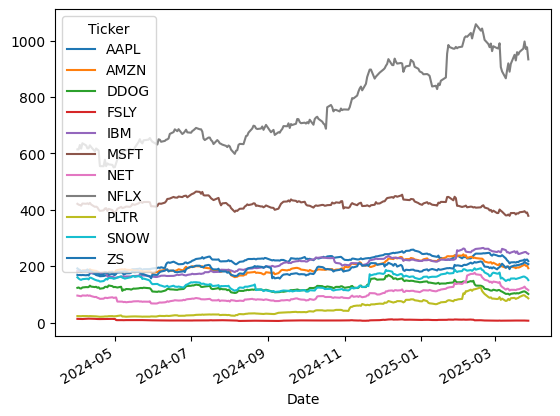

In [11]:
data.plot()

# 4. Preparing Data

## 4.1 Transformations

#### Annual Log- Returns

In [34]:
# remove last 20 rows (one natural month)
x = np.log(data.iloc[:-20,:] / data.iloc[:-20,:].shift()) * 252 # annual retorns
x.dropna(inplace = True)
x

Ticker,AAPL,AMZN,DDOG,FSLY,IBM,MSFT,NET,NFLX,PLTR,SNOW,ZS
Date,,,,,,,,,,,
2024-04-02,-1.769905,-0.390199,2.524700,-2.519054,-1.264283,-1.864672,-1.824281,-0.041015,-1.548067,-6.891026,-4.486058
2024-04-03,1.206049,2.387461,-5.903152,-4.717762,2.680743,-0.592657,-0.797309,6.428494,-0.221913,-5.167152,-3.265541
2024-04-04,-1.235866,-3.351618,-1.643735,-2.192178,-3.937993,-1.545101,-3.808497,-5.229226,-2.454216,-2.782010,-5.884286
2024-04-05,1.131865,6.999885,7.567149,-1.203832,1.603898,4.565651,7.743821,7.657172,5.324137,4.161570,1.834744
2024-04-08,-1.684813,0.163338,2.740035,18.976714,0.904380,-0.551358,-2.184571,-3.096766,0.438652,1.632553,0.508065
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,1.585718,-4.543619,-4.526871,-12.451382,0.375565,-2.612446,-6.654085,-3.715006,-28.033243,-10.072384,-1.923715
2025-02-25,-0.061210,0.106597,-5.484837,-5.530566,-3.996230,-3.833972,-8.414055,-2.879352,-8.018613,-10.107826,-5.181153
2025-02-26,-6.907934,1.828877,-3.553553,8.070551,-1.874348,1.156338,3.114389,3.284387,4.182318,3.035730,3.603227


### Expected values (Means)

In [35]:
# whole  year
means = np.array(x.mean()).reshape(-1,1)
means

array([[ 0.39286924],
       [ 0.17560204],
       [-0.06061507],
       [-0.71740482],
       [ 0.35007212],
       [-0.0655422 ],
       [ 0.45998288],
       [ 0.51459077],
       [ 1.44412609],
       [ 0.10816853],
       [ 0.0232359 ]])

# 5. Modeling


## 5.1 Simulation One Month

In [16]:
x_prueba = data.iloc[-20:, :].copy() # one moth of information
x_prueba

Ticker,AAPL,AMZN,DDOG,FSLY,IBM,MSFT,NET,NFLX,PLTR,SNOW,ZS
Date,,,,,,,,,,,
2025-03-03,238.029999,205.020004,113.169998,6.54,250.190002,388.489990,142.910004,973.700012,83.419998,173.649994,188.789993
2025-03-04,235.929993,203.800003,115.459999,6.60,253.210007,388.609985,140.929993,972.580017,84.400002,173.600006,193.820007
2025-03-05,235.740005,208.360001,115.089996,6.99,251.350006,401.019989,143.750000,990.919983,90.129997,177.309998,196.449997
2025-03-06,235.330002,200.699997,111.459999,6.50,248.690002,396.890015,131.020004,906.359985,80.459999,156.220001,202.160004
2025-03-07,239.070007,199.250000,109.629997,6.64,261.540009,393.309998,126.750000,891.109985,84.910004,158.910004,208.759995
2025-03-10,227.479996,194.539993,101.650002,6.60,256.899994,380.160004,116.610001,866.679993,76.379997,147.589996,194.690002
2025-03-11,220.839996,196.589996,101.959999,6.58,248.949997,380.450012,120.070000,895.099976,78.050003,149.899994,199.360001
2025-03-12,216.979996,198.889999,102.029999,6.76,249.630005,383.269989,119.400002,919.679993,83.650002,152.369995,197.789993
2025-03-13,209.679993,193.889999,98.680000,6.60,245.800003,378.769989,113.699997,890.169983,79.620003,149.830002,189.580002


In [17]:
# final earn
ganancia_mes_final =  x_prueba.iloc[-1,:] / x_prueba.iloc[1,:] -1
ganancia_mes_final

Ticker
AAPL   -0.076421
AMZN   -0.054367
DDOG   -0.124372
FSLY   -0.013636
IBM    -0.036373
MSFT   -0.025244
NET    -0.184560
NFLX   -0.039822
PLTR    0.017180
SNOW   -0.132316
ZS      0.068724
dtype: float64

## 5.2 Portfolios

/var/folders/dv/9p478lkj2vs4k52t0dflfcb1qd6rhx/T/ipykernel_58267/1315758700.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.63487083 0.63487083 0.63487083 0.63487083 0.63487083]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[cItems0] *= alpha # weight 1


{'icoord': [[55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [95.0, 95.0, 105.0, 105.0],
  [80.0, 80.0, 100.0, 100.0],
  [60.0, 60.0, 90.0, 90.0],
  [45.0, 45.0, 75.0, 75.0],
  [35.0, 35.0, 60.0, 60.0],
  [25.0, 25.0, 47.5, 47.5],
  [15.0, 15.0, 36.25, 36.25],
  [5.0, 5.0, 25.625, 25.625]],
 'dcoord': [[0.0,
   np.float64(0.4880944995530102),
   np.float64(0.4880944995530102),
   0.0],
  [0.0, np.float64(0.42199427216449886), np.float64(0.42199427216449886), 0.0],
  [0.0, np.float64(0.510446180028826), np.float64(0.510446180028826), 0.0],
  [np.float64(0.42199427216449886),
   np.float64(0.5128343337568845),
   np.float64(0.5128343337568845),
   np.float64(0.510446180028826)],
  [np.float64(0.4880944995530102),
   np.float64(0.5164232753322731),
   np.float64(0.5164232753322731),
   np.float64(0.5128343337568845)],
  [0.0,
   np.float64(0.5190254616983687),
   np.float64(0.5190254616983687),
   np.float64(0.5164232753322731)],
  [0.0,
   np.float64(0.5206022718477494),
   np.flo

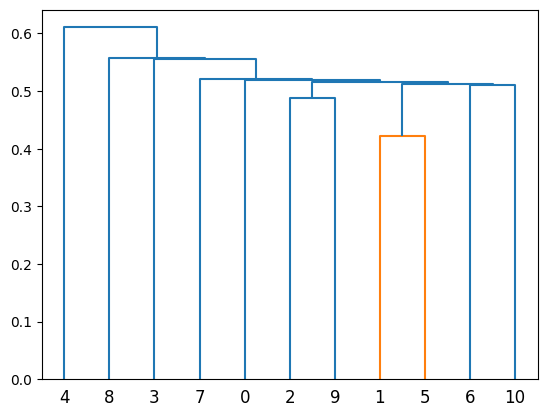

In [20]:
allocation, linkage = get_allocations(x, True)
sch.dendrogram(linkage)

In [21]:
data.columns

Index(['AAPL', 'AMZN', 'DDOG', 'FSLY', 'IBM', 'MSFT', 'NET', 'NFLX', 'PLTR',
       'SNOW', 'ZS'],
      dtype='object', name='Ticker')

In [22]:
allocation

,HRP,CLA
AAPL,0.207978,0.177330
AMZN,0.073097,0.000000
DDOG,0.048617,0.000000
FSLY,0.027128,0.000000
IBM,0.230026,0.353196
MSFT,0.166670,0.381555
NET,0.022613,0.000000
NFLX,0.134739,0.087919
PLTR,0.035000,0.000000
SNOW,0.023398,0.000000


Note that:
- HRP: split the weights using all assets
- CLA: generates ZERO weights

In [23]:
allocation.sum()

HRP    1.0
CLA    1.0
dtype: float64

## 6. Evaluation

<Axes: xlabel='Date'>

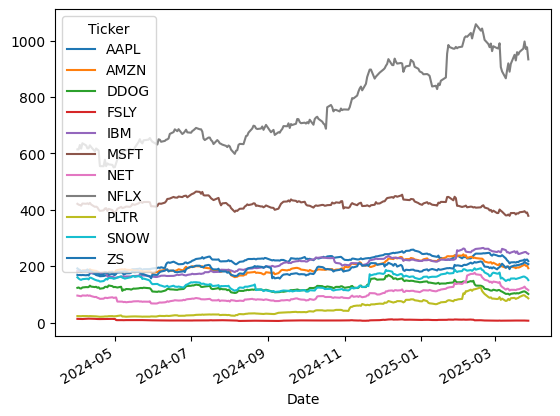

In [24]:
data.plot()

In [27]:
ganancia_mes_final

Ticker
AAPL   -0.076421
AMZN   -0.054367
DDOG   -0.124372
FSLY   -0.013636
IBM    -0.036373
MSFT   -0.025244
NET    -0.184560
NFLX   -0.039822
PLTR    0.017180
SNOW   -0.132316
ZS      0.068724
dtype: float64

In [28]:
# get the distribution of money among all assets
capital_inicial = 1e6
allocation['HRP'] * capital_inicial

AAPL    207977.661977
AMZN     73096.550700
DDOG     48616.756168
FSLY     27128.485768
IBM     230025.774953
MSFT    166670.235578
NET      22612.854384
NFLX    134739.351083
PLTR     34999.557623
SNOW     23398.047140
ZS       30734.724626
Name: HRP, dtype: float64

In [32]:
# get the final return: earning at the end of one month
np.dot(allocation['HRP']*capital_inicial, ganancia_mes_final + 1)

np.float64(951220.0423624995)

In [33]:
# get the final return: earning at the end of one month
np.dot(allocation['CLA']*capital_inicial, ganancia_mes_final + 1)

np.float64(960468.4629270879)

In [37]:
import plotly.express as px

px.line(data)